In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [2]:
import numpy as np
from core.metrics import pmse
from core.linalg_utils import circular_aperture, random_unitary_matrix
from graph.structure.graph import Graph
from graph.prior.support_prior import SupportPrior
from graph.propagator.unitary_propagator import UnitaryPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

# ==== 1. パラメータ ====
n = 256
m = int(3*n)
shape = (m,)
rng = np.random.default_rng(seed=123)
var = 1e-4
U = random_unitary_matrix(m, rng=rng)

# Support mask: center half active
support = np.zeros(shape, dtype=bool)
support[n:2*n] = True

# ==== 2. グラフ定義 ====
class SimplePhaseGraph(Graph):
    def __init__(self):
        super().__init__()
        x = ~SupportPrior(support=support, label = "x")
        y = UnitaryPropagator(U) @ x
        with self.observe():
            z = AmplitudeMeasurement(var=var, damping=0.3) @ y
        self.compile()

# ==== 3. 初期化とデータ生成 ====
g = SimplePhaseGraph()
g.set_init_rng(np.random.default_rng(seed=11))

g.generate_sample(rng=np.random.default_rng(seed=999), update_observed = True)
X = g.get_wave("x")
true_x = X.get_sample()

# ==== 4. 推論（Belief Propagation） ====
def monitor(graph, t):
    if t % 20 == 0:
        est = X.compute_belief().data
        err = pmse(est, true_x)
        print(f"[t={t}] PMSE = {err:.3e}")

g.run(n_iter=100, callback=monitor, verbose = False)

# ==== 5. 結果 ====
final_est = X.compute_belief().data
final_err = pmse(final_est, true_x)
print(f"\nFinal PMSE after 100 iterations: {final_err:.3e}")

[t=0] PMSE = 7.386e-01
[t=20] PMSE = 3.376e-01
[t=40] PMSE = 9.361e-04
[t=60] PMSE = 2.423e-04
[t=80] PMSE = 2.407e-04

Final PMSE after 100 iterations: 2.407e-04


In [3]:
%prun -l 40 -s cumulative g.run(n_iter=100, callback=monitor)

BP Iteration: 100%|██████████| 100/100 [00:00<00:00, 1704.50it/s]

[t=0] PMSE = 2.407e-04
[t=20] PMSE = 2.407e-04
[t=40] PMSE = 2.407e-04
[t=60] PMSE = 2.407e-04
[t=80] PMSE = 2.407e-04
 

         32739 function calls (32579 primitive calls) in 0.085 seconds

   Ordered by: cumulative time
   List reduced from 531 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     16/1    0.000    0.000    0.085    0.085 {built-in method builtins.exec}
        1    0.000    0.000    0.085    0.085 <string>:1(<module>)
        1    0.000    0.000    0.085    0.085 graph.py:160(run)
      100    0.000    0.000    0.055    0.001 graph.py:155(backward)
      100    0.000    0.000    0.044    0.000 unitary_propagator.py:128(backward)
      100    0.037    0.000    0.041    0.000 unitary_propagator.py:74(compute_belief)
     16/3    0.000    0.000    0.024    0.008 <frozen importlib._bootstrap>:1022(_find_and_load)
     16/3    0.000    0.000    0.024    0.008 <frozen importlib._bootstrap>:987(_find_and_load_unlocked)
     16/3    0.000    0.000    0.023    0.008 <frozen importlib._bootstrap>:664(_load_unlocked)
     15/3    0.000    0.

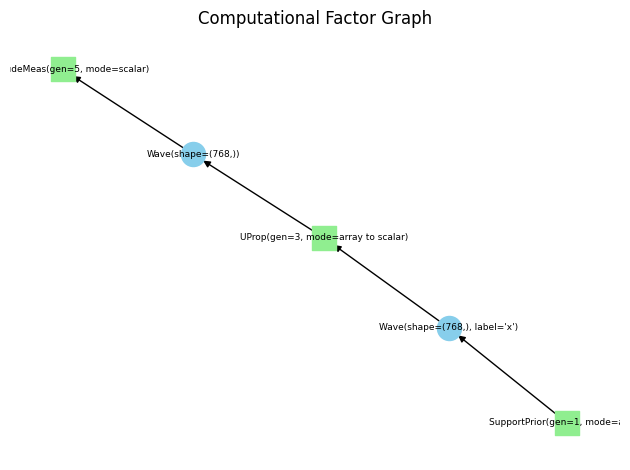

In [4]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)

## Fourier Phase Retrieval

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from core.metrics import pmse
from core.linalg_utils import circular_aperture, random_phase_mask
from graph.structure.graph import Graph
from graph.prior.support_prior import SupportPrior
from graph.propagator.phase_mask_propagator import PhaseMaskPropagator
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

# ==== 1. パラメータ ====
H, W = 128, 128
shape = (H, W)
var = 1e-4
support_radius = 0.2
rng = np.random.default_rng(seed=42)
support = circular_aperture(shape, radius=support_radius)

class StructuredRandomGraph(Graph):
    def __init__(self, n_layers=1):
        super().__init__()
        # Support Prior
        x = ~SupportPrior(support=support, label = "object")
        # Random Structured Matrix
        for i in range(n_layers):
            phase = random_phase_mask(shape, rng=rng)
            x = FFT2DPropagator() @ (PhaseMaskPropagator(phase) @ x)
        with self.observe():
            z = AmplitudeMeasurement(var=var, damping=0.3) @ x
        self.compile()

# ==== 4. 初期化と推論 ====
g = StructuredRandomGraph(n_layers=3)
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)
X = g.get_wave("object")
true_x = X.get_sample()

def monitor(graph, t):
    X = graph.get_wave("object")
    est = X.compute_belief().data
    err = pmse(est, true_x)
    if t % 50 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=300, callback=monitor, verbose = False)

[t=0] PMSE = 2.47071e-01
[t=50] PMSE = 9.20200e-04
[t=100] PMSE = 5.85127e-05
[t=150] PMSE = 5.58583e-05
[t=200] PMSE = 5.58663e-05
[t=250] PMSE = 5.58657e-05


In [6]:
%prun -l 40 -s cumulative g.run(n_iter=100, callback=None)

BP Iteration: 100%|██████████| 100/100 [00:00<00:00, 322.38it/s]

         101912 function calls in 0.312 seconds

   Ordered by: cumulative time
   List reduced from 229 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.312    0.312 {built-in method builtins.exec}
        1    0.000    0.000    0.312    0.312 <string>:1(<module>)
        1    0.000    0.000    0.312    0.312 graph.py:160(run)
      100    0.001    0.000    0.264    0.003 graph.py:155(backward)
      300    0.001    0.000    0.194    0.001 fft_2d_propagator.py:111(backward)
      300    0.022    0.000    0.160    0.001 fft_2d_propagator.py:60(compute_belief)
      600    0.002    0.000    0.099    0.000 _pocketfft.py:701(_raw_fftnd)
     1200    0.002    0.000    0.087    0.000 _pocketfft.py:49(_raw_fft)
     1200    0.083    0.000    0.083    0.000 {built-in method numpy.fft._pocketfft_internal.execute}
      700    0.061    0.000    0.065    0.000 uncertain_array.py:332(__truediv__)
      300    0

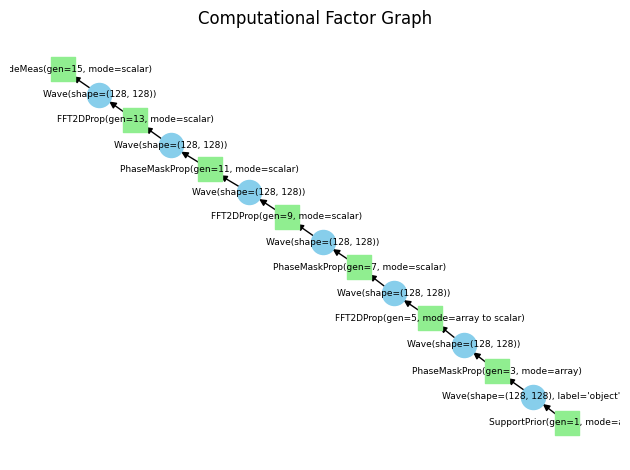

In [7]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)